In [2]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [27]:
df = pd.read_csv("preprocessed.csv")
df.set_index("datetime", drop=False, inplace=True)
df.head()

,datetime,gh,csky_ghi,tdry,wspd,pres_hpa,rhum,snowd_m,rainfall,consumption
datetime,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,0.0000,0.0000,-0.84,1.51,905.63,50.91,0.0,0.001754,753.583333
2020-01-01 04:00:00,2020-01-01 04:00:00,0.0000,0.0000,-3.22,2.37,905.38,65.06,0.0,0.000000,771.250000
2020-01-01 05:00:00,2020-01-01 05:00:00,0.0000,0.0000,-4.01,2.29,905.68,72.50,0.0,0.000000,862.500000
2020-01-01 06:00:00,2020-01-01 06:00:00,0.0000,0.0000,-5.10,2.34,905.90,81.69,0.0,0.000000,644.951667
2020-01-01 07:00:00,2020-01-01 07:00:00,43.2151,48.5114,-5.58,2.53,906.16,88.32,0.0,0.000000,646.215000


In [31]:
loc = int(len(df.consumption) * 0.66)
DATE = df['datetime'][loc]
DATE

Timestamp('2020-02-10 09:00:00')

In [32]:
df.reset_index(drop=True, inplace=True)
lag_features = ['gh', 'csky_ghi', 'tdry', 'wspd', 'pres_hpa', 'rhum', 'snowd_m', 'rainfall']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
 df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
 df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
 df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

 df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
 df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
 df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("datetime", drop=False, inplace=True)
df.head()

,datetime,gh,csky_ghi,tdry,wspd,pres_hpa,rhum,snowd_m,rainfall,consumption,...,snowd_m_mean_lag30,snowd_m_std_lag3,snowd_m_std_lag7,snowd_m_std_lag30,rainfall_mean_lag3,rainfall_mean_lag7,rainfall_mean_lag30,rainfall_std_lag3,rainfall_std_lag7,rainfall_std_lag30
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,2020-01-01 00:00:00,0.0000,0.0000,-0.84,1.51,905.63,50.91,0.0,0.001754,753.583333,...,0.004619,0.000122,0.000272,0.001134,0.055550,0.055548,0.055546,2.089115e-02,0.038453,0.087041
2020-01-01 04:00:00,2020-01-01 04:00:00,0.0000,0.0000,-3.22,2.37,905.38,65.06,0.0,0.000000,771.250000,...,0.000000,0.000122,0.000272,0.001134,0.001754,0.001754,0.001754,2.089115e-02,0.038453,0.087041
2020-01-01 05:00:00,2020-01-01 05:00:00,0.0000,0.0000,-4.01,2.29,905.68,72.50,0.0,0.000000,862.500000,...,0.000000,0.000000,0.000000,0.000000,0.000877,0.000877,0.000877,1.240265e-03,0.001240,0.001240
2020-01-01 06:00:00,2020-01-01 06:00:00,0.0000,0.0000,-5.10,2.34,905.90,81.69,0.0,0.000000,644.951667,...,0.000000,0.000000,0.000000,0.000000,0.000585,0.000585,0.000585,1.012672e-03,0.001013,0.001013
2020-01-01 07:00:00,2020-01-01 07:00:00,43.2151,48.5114,-5.58,2.53,906.16,88.32,0.0,0.000000,646.215000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000438,0.000438,1.455192e-11,0.000877,0.000877


In [33]:
df.datetime = pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S")
df["month"] = df.datetime.dt.month
df["week"] = df.datetime.dt.week
df["day"] = df.datetime.dt.day
df["day_of_week"] = df.datetime.dt.dayofweek

In [34]:
df_train = df[df.datetime < DATE]
df_valid = df[df.datetime >= DATE]

In [35]:
exogenous_features = ["gh_mean_lag3", "gh_std_lag3", "tdry_mean_lag3", "tdry_std_lag3","wspd_mean_lag3","wspd_std_lag3","rhum_mean_lag3", "rhum_std_lag3", "rainfall_mean_lag3", "rainfall_std_lag3",
"gh_mean_lag7", "gh_std_lag7", "tdry_mean_lag7", "tdry_std_lag7",
"wspd_mean_lag7", "wspd_std_lag7", "rhum_mean_lag7",
"rhum_std_lag7", "rainfall_mean_lag7", "rainfall_std_lag7",
"gh_mean_lag30", "gh_std_lag30", "tdry_mean_lag30", "tdry_std_lag30",
"wspd_mean_lag30", "wspd_std_lag30", "rhum_mean_lag30",
"rhum_std_lag30", "rainfall_mean_lag30", "rainfall_std_lag30",
"month", "week", "day", "day_of_week"]

In [36]:
model = auto_arima(df_train.consumption, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.consumption, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=12091.014, BIC=12285.567, Time=8.637 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=12184.813, BIC=12359.910, Time=0.328 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=12123.623, BIC=12303.584, Time=7.087 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=12115.276, BIC=12295.237, Time=6.119 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=12182.814, BIC=12353.047, Time=7.748 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=12101.338, BIC=12291.026, Time=8.966 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=12116.348, BIC=12306.036, Time=6.691 seconds
Fit ARIMA(3,0,2)x(0,0,0,0) [intercept=True]; AIC=12086.417, BIC=12285.833, Time=8.842 seconds
Fit ARIMA(3,0,1)x(0,0,0,0) [intercept=True]; AIC=12087.363, BIC=12281.915, Time=9.050 seconds
Fit ARIMA(4,0,2)x(0,0,0,0) [intercept=True]; AIC=12093.529, BIC=12297.808, Time=8.204 seconds
Fit ARIMA(3,0,3)

C:\Users\risto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


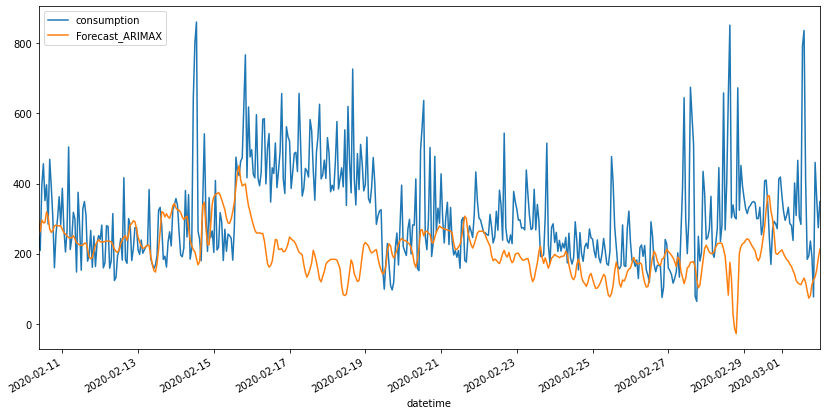

In [37]:
df_valid[["consumption", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [38]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.consumption, df_valid.Forecast_ARIMAX)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.consumption, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 177.51653257426798

MAE of Auto ARIMAX: 126.69929386305448


In [39]:
model_without_exogenous = auto_arima(df_train.consumption,start_p=1, start_q=1,
                           max_p=5, max_q=5, m=1,
                           #exogenous=df_train[exogenous_features],
                       trace=True, error_action="ignore", suppress_warnings=True)
model_without_exogenous.fit(df_train.consumption
          #, exogenous=df_train[exogenous_features]
         )

forecast = model_without_exogenous.predict(n_periods=len(df_valid)
                         #, exogenous=df_valid[exogenous_features]
                        )
df_valid["Forecast_ARIMAX without exogenous"] = forecast

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=12067.611, BIC=12087.063, Time=0.426 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=12490.902, BIC=12500.628, Time=0.095 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=12376.130, BIC=12390.718, Time=0.062 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=12090.676, BIC=12105.265, Time=0.226 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=12488.905, BIC=12493.768, Time=0.015 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=12053.767, BIC=12078.081, Time=0.740 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=12188.905, BIC=12208.356, Time=0.133 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=12042.096, BIC=12071.272, Time=0.940 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=12145.341, BIC=12169.655, Time=0.130 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=12043.272, BIC=12077.312, Time=1.506 seconds
Fit ARIMA(3,1,2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


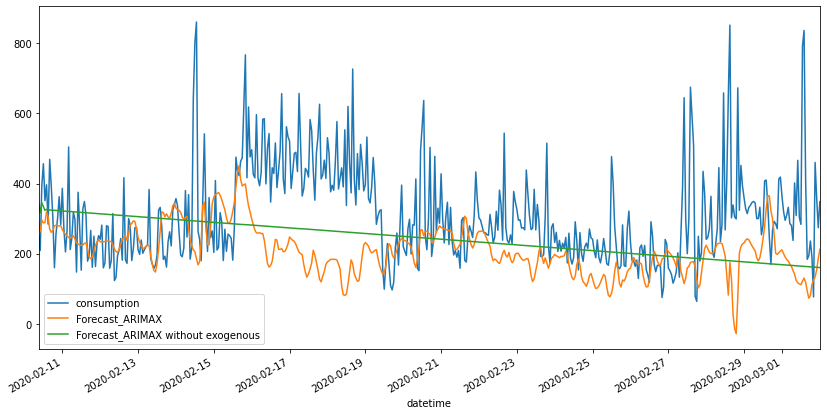

In [40]:
df_valid[["consumption", "Forecast_ARIMAX", "Forecast_ARIMAX without exogenous"]].plot(figsize=(14, 7))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


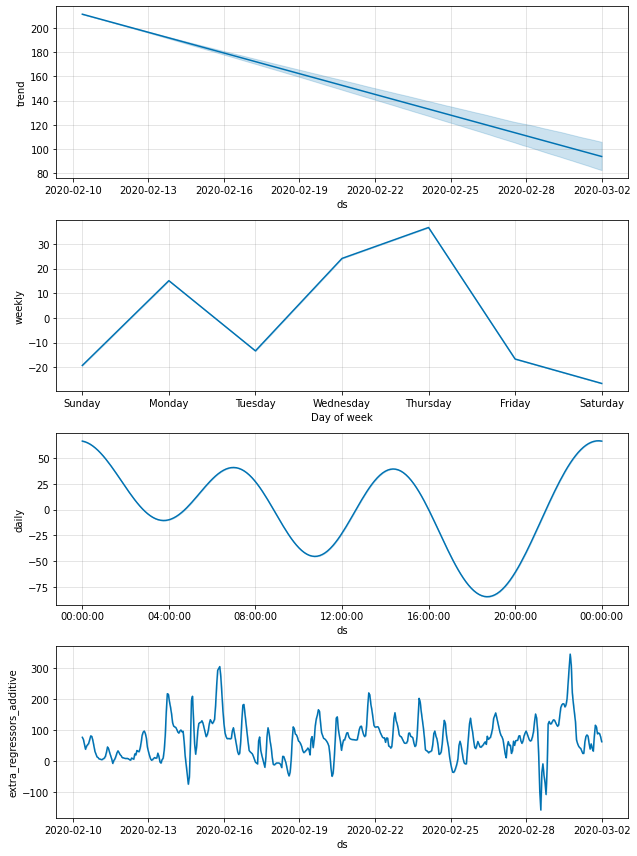

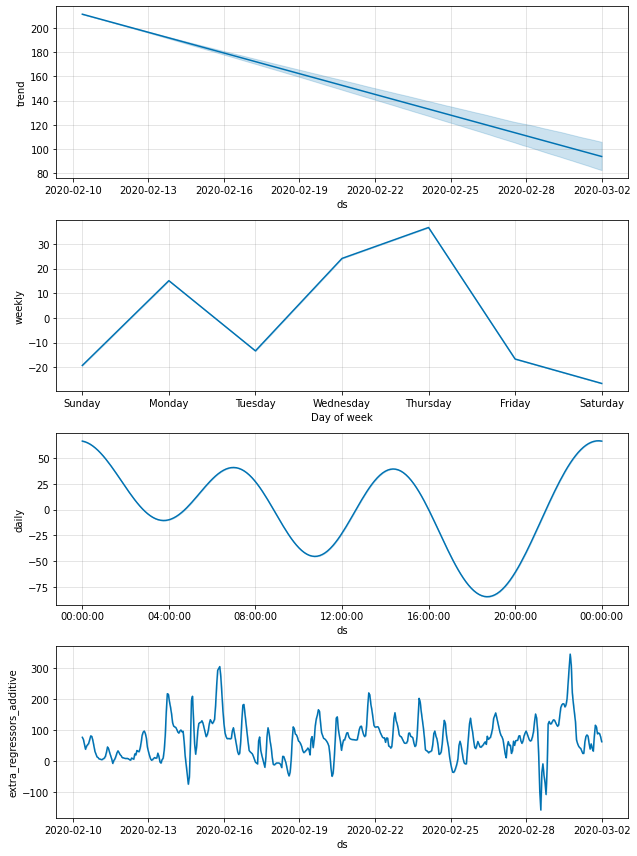

In [41]:
model_fbp = Prophet(mcmc_samples = 300)
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["datetime", "consumption"] + exogenous_features].rename(columns={"datetime": "ds", "consumption": "y"}))
forecast = model_fbp.predict(df_valid[["datetime", "consumption"] + exogenous_features].rename(columns={"datetime": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values
model_fbp.plot_components(forecast)

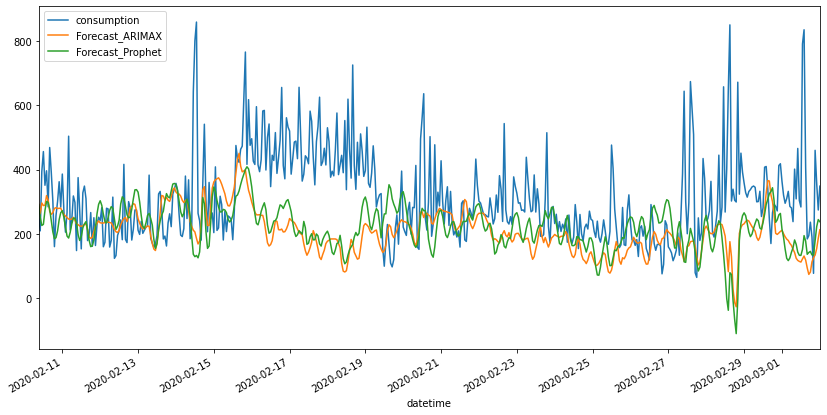

In [42]:
df_valid[["consumption", "Forecast_ARIMAX", "Forecast_Prophet"]].plot(figsize=(14, 7))

In [43]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.consumption, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:", np.sqrt(mean_squared_error(df_valid.consumption, df_valid.Forecast_Prophet)))
print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.consumption, df_valid.Forecast_ARIMAX))
print("MAE of Prophet:", mean_absolute_error(df_valid.consumption, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX: 177.51653257426798
RMSE of Prophet: 175.36086146445115

MAE of Auto ARIMAX: 126.69929386305448
MAE of Prophet: 124.30907166312728
